In [ ]:
import string
import re
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Embedding, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint , EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
file = open("/content/ita.txt", mode='rt', encoding='utf-8')
data = file.read()
file.close()

In [ ]:
# split a text into sentences
ita_eng = data.strip().split('\n')
ita_eng = [i.split('\t') for i in ita_eng]
ita_eng= np.array(ita_eng)
print(ita_eng)

[['Hi.' 'Ciao!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #607364 (Cero)']
 ['Run!' 'Corri!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906347 (Guybrush88)']
 ['Run!' 'Corra!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906348 (Guybrush88)']
 ...
 ["If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker."
  'Se qualcuno che non conosce il tuo background dice che sembri un madrelingua, significa che probabilmente ha notato qualcosa sul tuo modo di parlare che ha fatto capire che non eri un madrelingua. In altre parole, non sembri davvero un madrelingua.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #953936 (CK) & #6473513 (Guybrush88)']
 ['Doubtless there exists in this world precisely the right woman for any gi

In [ ]:
#taking 1st 50 thousand samples to reduce training time
ita_eng=ita_eng[:60000,:]

In [ ]:
# Remove punctuation
ita_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ita_eng[:,0]]
ita_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ita_eng[:,1]]

ita_eng

array([['Hi', 'Ciao',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #607364 (Cero)'],
       ['Run', 'Corri',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906347 (Guybrush88)'],
       ['Run', 'Corra',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906348 (Guybrush88)'],
       ...,
       ['I need more coffee', 'Ho bisogno di più caffè',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #6050351 (Hybrid) & #7675514 (Guybrush88)'],
       ['I need more coffee', 'Io ho bisogno di più caffè',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #6050351 (Hybrid) & #7675515 (Guybrush88)'],
       ['I need more coffee', 'Mi serve più caffè',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #6050351 (Hybrid) & #7675516 (Guybrush88)']],
      dtype='<U537')

In [ ]:
# convert text to lowercase
for i in range(len(ita_eng)):
    ita_eng[i,0] = ita_eng[i,0].lower()
    ita_eng[i,1] = ita_eng[i,1].lower()

In [ ]:
def tokenization(sents):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sents)
    return tokenizer

In [ ]:
# prepare english tokenizer

eng_tokenizer = tokenization(ita_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 16
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 4701


In [ ]:
# prepare italian tokenizer
ita_tokenizer = tokenization(ita_eng[:, 1])
ita_vocab_size = len(ita_tokenizer.word_index) + 1

ita_length = 16
print('Deutch Vocabulary Size: %d' % ita_vocab_size)

Deutch Vocabulary Size: 10709


In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, sents):
    seq = tokenizer.texts_to_sequences(sents)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [ ]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(ita_eng, test_size=0.2, random_state = 12)

In [ ]:
# prepare training data
X_train = encode_sequences(ita_tokenizer, ita_length, train[:, 1])
Y_train = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
X_test = encode_sequences(ita_tokenizer, ita_length, test[:, 1])
Y_test = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [ ]:
def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [ ]:
# model compilation
model = define_model(ita_vocab_size, eng_vocab_size, ita_length, eng_length, 512)

In [ ]:
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
# Define the checkpoint to save the best model during training
filename = '/content/drive/My Drive/model.h1.best.keras'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

# Train the model and save the best version during training
history = model.fit(X_train, Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1),
                    epochs=150, batch_size=512, validation_split=0.2, callbacks=[checkpoint, early_stopping],
                    verbose=1)


Epoch 1/150
75/75 [==============================] - ETA: 0s - loss: 2.2144
Epoch 1: val_loss improved from inf to 1.49485, saving model to /content/drive/My Drive/model.h1.best.keras
75/75 [==============================] - 19s 162ms/step - loss: 2.2144 - val_loss: 1.4948
Epoch 2/150
75/75 [==============================] - ETA: 0s - loss: 1.3615
Epoch 2: val_loss improved from 1.49485 to 1.27798, saving model to /content/drive/My Drive/model.h1.best.keras
75/75 [==============================] - 8s 103ms/step - loss: 1.3615 - val_loss: 1.2780
Epoch 3/150
75/75 [==============================] - ETA: 0s - loss: 1.2472
Epoch 3: val_loss improved from 1.27798 to 1.22646, saving model to /content/drive/My Drive/model.h1.best.keras
75/75 [==============================] - 8s 104ms/step - loss: 1.2472 - val_loss: 1.2265
Epoch 4/150
75/75 [==============================] - ETA: 0s - loss: 1.2180
Epoch 4: val_loss improved from 1.22646 to 1.20946, saving model to /content/drive/My Drive/mode

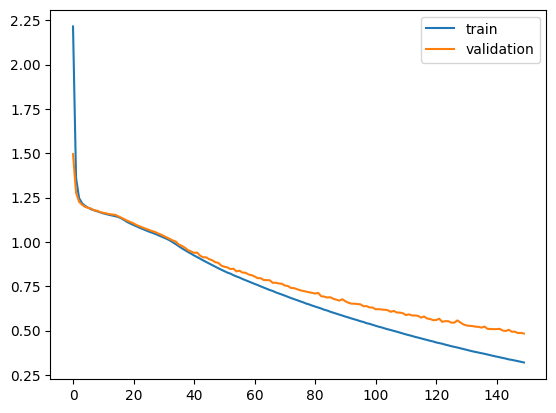

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
model = load_model('/content/drive/My Drive/model.h1.best.keras')
predictions = model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1])))

# Use np.argmax to get the indices of the maximum probabilities
predicted_classes = np.argmax(predictions, axis=-1)

print(predicted_classes)

375/375 [==============================] - 4s 5ms/step
[[   1   41   19 ...    0    0    0]
 [  16   25 1102 ...    0    0    0]
 [  11    3   42 ...    0    0    0]
 ...
 [   7    1   30 ...    0    0    0]
 [  70   10   14 ...    0    0    0]
 [   1   35   26 ...    0    0    0]]


In [ ]:
def get_word(index, tokenizer):
    # Get the word corresponding to an index from the tokenizer
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

# Assuming predicted_classes is a list of lists of indices
preds_text = []
for i in predicted_classes:
    temp = []
    for j in range(len(i)):
        word = get_word(i[j], eng_tokenizer)  # Get the word for the current index
        if word is None:
            word = ''  # Handle cases where index is not found

        # Check if the word is the same as the previous word or is None
        if j > 0 and (word == get_word(i[j-1], eng_tokenizer) or word == ''):
            temp.append('')  # Skip duplicates
        else:
            temp.append(word)

    preds_text.append(' '.join(temp))  # Join words to form a sentence

# Print or use preds_text
print(preds_text)


['i love this             ', 'were not cowards             ', 'do you know tom            ', 'stop up              ', 'its a big             ', 'take this one             ', 'everyone loves it             ', 'what do i do            ', 'you  need money            ', 'i slept              ', 'im am of             ', 'i lost my             ', 'youre you              ', 'are you dyslexic             ', 'i paid              ', 'who did tom             ', 'ill tom              ', 'the it opened             ', 'i followed tom             ', 'i found your keys            ', 'he wrong fast             ', 'youre married              ', 'im not cranky             ', 'i forgot the book            ', 'i want a friend            ', 'i stayed home             ', 'tom has a drunk            ', 'you look tired             ', 'whats was that             ', 'they are luck             ', 'i like this place            ', 'use this              ', 'did you run             ', 'i must get a            ', 'yo

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
pred_df.head(50)

,actual,predicted
0,i love this part,i love this
1,were not cowards,were not cowards
2,do you love tom,do you know tom
3,theyre coming,stop up
4,its a doll,its a big
5,take this aspirin,take this one
6,anybody knows it,everyone loves it
7,what do i owe you,what do i do
8,do you need money,you need money
9,i prepaid,i slept
